# Market Direction Prediction with LSTM and Variational Quantum Classifier

## Setup and Installation

In [1]:
import sys, subprocess
def pip_install(pkg):
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])
for pkg in ['yfinance', 'pandas', 'numpy', 'scikit-learn', 'matplotlib', 'seaborn', 'ta', 'tensorflow', 'pennylane', 'huggingface_hub']:
    pip_install(pkg)

## Imports and Configuration

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator, EMAIndicator
from ta.volatility import BollingerBands
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pennylane as qml
import os
pd.options.display.float_format = '{:.6f}'.format
np.random.seed(42)
tf.random.set_seed(42)

## Download 5–10 Years of Data

In [3]:
ticker = 'TQQQ'
years = 10
end = pd.Timestamp.today().normalize()
start = end - pd.DateOffset(years=years)
df = yf.download(ticker, start=start, end=end, auto_adjust=True)
df = df.rename(columns={'Close':'close','High':'high','Low':'low','Volume':'volume'})
df = df[['close','high','low','volume']]
df.head()

[*********************100%***********************]  1 of 1 completed

Price,close,high,low,volume
Ticker,TQQQ,TQQQ,TQQQ,TQQQ
Date,,,,
2015-11-16,4.509413,4.516187,4.284301,92772000
2015-11-17,4.524951,4.620176,4.488295,110707200
2015-11-18,4.784328,4.797078,4.563997,98138400
2015-11-19,4.791500,4.858436,4.766798,51979200
2015-11-20,4.886724,4.900669,4.846483,50997600


## Compute Features and Labels

In [4]:
close_series = pd.Series(df['close'].values.ravel(), index=df.index)
rsi = RSIIndicator(close=close_series, window=14).rsi()
macd = MACD(close=close_series, window_slow=26, window_fast=12, window_sign=9)
sma10 = SMAIndicator(close=close_series, window=10).sma_indicator()
ema10 = EMAIndicator(close=close_series, window=10).ema_indicator()
sma20 = SMAIndicator(close=close_series, window=20).sma_indicator()
ema20 = EMAIndicator(close=close_series, window=20).ema_indicator()
sma50 = SMAIndicator(close=close_series, window=50).sma_indicator()
ema50 = EMAIndicator(close=close_series, window=50).ema_indicator()
bb = BollingerBands(close=close_series, window=20, window_dev=2)
df['rsi'] = rsi
df['macd'] = macd.macd()
df['macd_signal'] = macd.macd_signal()
df['sma10'] = sma10
df['ema10'] = ema10
df['sma20'] = sma20
df['ema20'] = ema20
df['sma50'] = sma50
df['ema50'] = ema50
df['bb_h'] = bb.bollinger_hband()
df['bb_l'] = bb.bollinger_lband()
df['returns'] = close_series.pct_change()
df['label'] = (close_series.shift(-1) >= close_series).astype(int)
df = df.dropna()
df = df[df['returns'].abs() >= 0.02]
features = ['close','high','low','volume','rsi','macd','macd_signal','sma10','ema10','sma20','ema20','sma50','ema50','bb_h','bb_l','returns']
X = df[features].values
y = df['label'].values
dates = df.index
len(df)

1236

## Train/Validation/Test Split and Scaling

In [5]:
n = len(df)
n_train = int(n*0.7)
n_val = int(n*0.15)
X_train, X_val, X_test = X[:n_train], X[n_train:n_train+n_val], X[n_train+n_val:]
y_train, y_val, y_test = y[:n_train], y[n_train:n_train+n_val], y[n_train+n_val:]
dates_train, dates_val, dates_test = dates[:n_train], dates[n_train:n_train+n_val], dates[n_train+n_val:]
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape

((865, 16), (185, 16), (186, 16))

## Sequence Generation (60-Day Window) for LSTM

In [6]:
window = 60
def make_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i-window:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)
X_train_seq, y_train_seq = make_sequences(X_train_scaled, y_train, window)
X_val_seq, y_val_seq = make_sequences(X_val_scaled, y_val, window)
X_test_seq, y_test_seq = make_sequences(X_test_scaled, y_test, window)
dates_train_seq = dates_train[window:]
dates_val_seq = dates_val[window:]
dates_test_seq = dates_test[window:]
X_train_seq.shape, X_val_seq.shape, X_test_seq.shape

((805, 60, 16), (125, 60, 16), (126, 60, 16))

## LSTM Classifier (TensorFlow)

In [7]:
inputs = tf.keras.Input(shape=(window, X_train.shape[1]))
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(inputs)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LSTM(32)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
lstm_model = tf.keras.Model(inputs, outputs)
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
es = tf.keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True, monitor='val_accuracy', mode='max')
rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, min_lr=1e-5, mode='max')
history = lstm_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=150, batch_size=64, callbacks=[es, rlrop], verbose=0)
lstm_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape            ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)       │ (None, 60, 16)          │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ bidirectional (Bidirectional)  │ (None, 60, 256)         │      148,480 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ dropout (Dropout)              │ (None, 60, 256)         │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ bidirectional_1                │ (None, 60, 128)         │      164,352 │
│ (Bidirectional)                │                         │              │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ dropout_1 (Dropout)            │ (None, 60, 128)         │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ lstm_2 (LSTM)                  │ (None, 32)              │       20,608 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ dense (Dense)                  │ (None, 64)              │        2,112 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ dense_1 (Dense)                │ (None, 1)               │           65 │
└────────────────────────────────┴─────────────────────────┴──────────────┘

 Total params: 1,006,853 (3.84 MB)

 Trainable params: 335,617 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 671,236 (2.56 MB)

## LSTM Evaluation and Plots

Best threshold: 0.1
0.5555555555555556
[[ 0 56]
 [ 0 70]]
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        56
           1     0.5556    1.0000    0.7143        70

    accuracy                         0.5556       126
   macro avg     0.2778    0.5000    0.3571       126
weighted avg     0.3086    0.5556    0.3968       126



C:\Users\ADMIN\OneDrive\Attachments\Documents\STClub\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ADMIN\OneDrive\Attachments\Documents\STClub\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ADMIN\OneDrive\Attachments\Documents\STClub\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

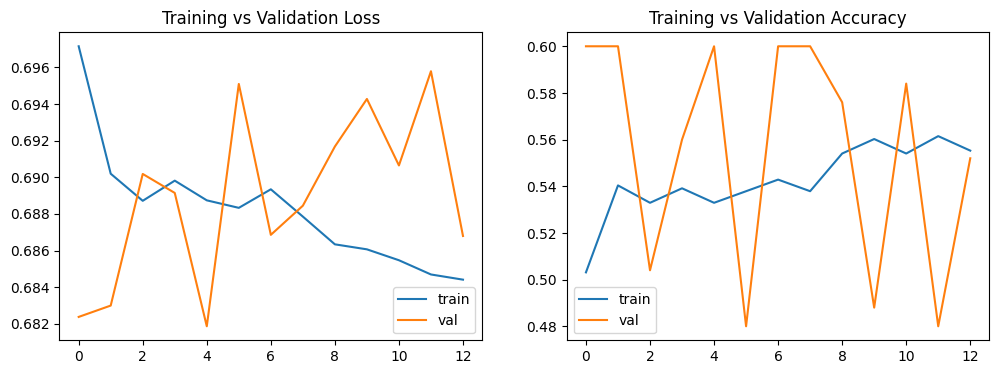

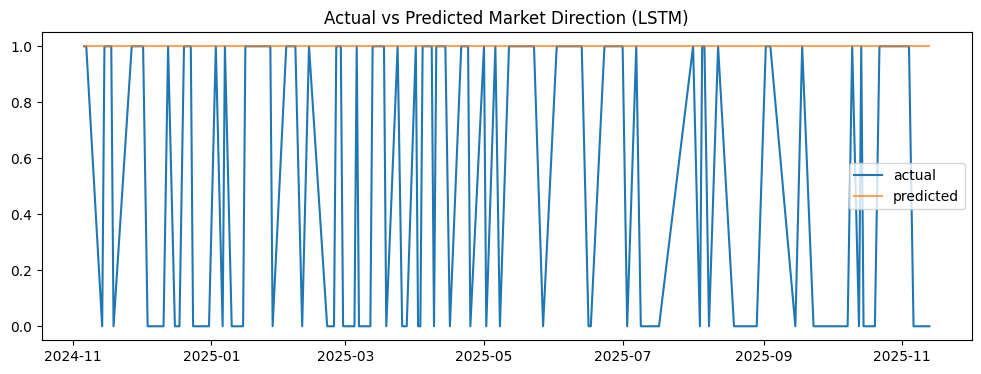

In [8]:
y_val_prob = lstm_model.predict(X_val_seq, verbose=0).ravel()
thresholds = np.linspace(0.1, 0.9, 81)
val_accs = []
for t in thresholds:
    val_accs.append(accuracy_score(y_val_seq, (y_val_prob >= t).astype(int)))
best_t = float(thresholds[int(np.argmax(val_accs))])
y_pred_prob = lstm_model.predict(X_test_seq, verbose=0).ravel()
y_pred = (y_pred_prob >= best_t).astype(int)
acc = accuracy_score(y_test_seq, y_pred)
cm = confusion_matrix(y_test_seq, y_pred)
cr = classification_report(y_test_seq, y_pred, digits=4)
print('Best threshold:', best_t)
print(acc)
print(cm)
print(cr)
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Training vs Validation Loss')
axes[0].legend(['train','val'])
axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title('Training vs Validation Accuracy')
axes[1].legend(['train','val'])
plt.show()
plt.figure(figsize=(12,4))
plt.plot(dates_test_seq, y_test_seq, label='actual')
plt.plot(dates_test_seq, y_pred, label='predicted', alpha=0.7)
plt.title('Actual vs Predicted Market Direction (LSTM)')
plt.legend()
plt.show()

## Variational Quantum Classifier (PennyLane, 4 Qubits)

In [9]:
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)
n_qubits = 4
n_layers = 3
dev = qml.device('default.qubit', wires=n_qubits)
@qml.qnode(dev)
def vqc(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))
weights = 0.01 * np.random.randn(n_layers, n_qubits)
def predict_proba(X, w):
    outs = [vqc(x, w) for x in X]
    return (np.array(outs) + 1)/2.0
def loss(w, X, y):
    p = predict_proba(X, w).ravel()
    p = np.clip(p, 1e-6, 1-1e-6)
    return -np.mean(y*np.log(p) + (1-y)*np.log(1-p))
opt = qml.GradientDescentOptimizer(stepsize=0.2)
train_losses, val_losses = [], []
for epoch in range(60):
    weights = opt.step(lambda w: loss(w, X_train_pca, y_train), weights)
    tl = loss(weights, X_train_pca, y_train)
    vl = loss(weights, X_val_pca, y_val)
    train_losses.append(tl)
    val_losses.append(vl)
hist_q = {'loss': train_losses, 'val_loss': val_losses, 'accuracy': [], 'val_accuracy': []}

C:\Users\ADMIN\OneDrive\Attachments\Documents\STClub\.venv\Lib\site-packages\pennylane\_grad.py:310: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


## VQC Evaluation and Plots

0.5591397849462365
[[  0  82]
 [  0 104]]
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        82
           1     0.5591    1.0000    0.7172       104

    accuracy                         0.5591       186
   macro avg     0.2796    0.5000    0.3586       186
weighted avg     0.3126    0.5591    0.4010       186



C:\Users\ADMIN\OneDrive\Attachments\Documents\STClub\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ADMIN\OneDrive\Attachments\Documents\STClub\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ADMIN\OneDrive\Attachments\Documents\STClub\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

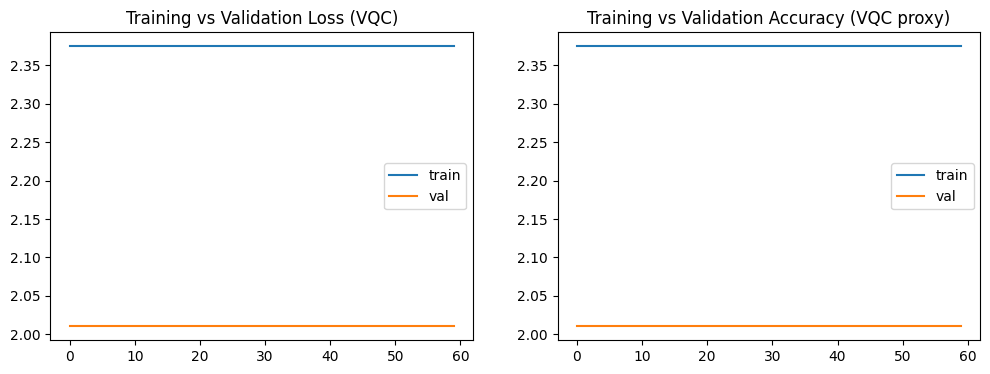

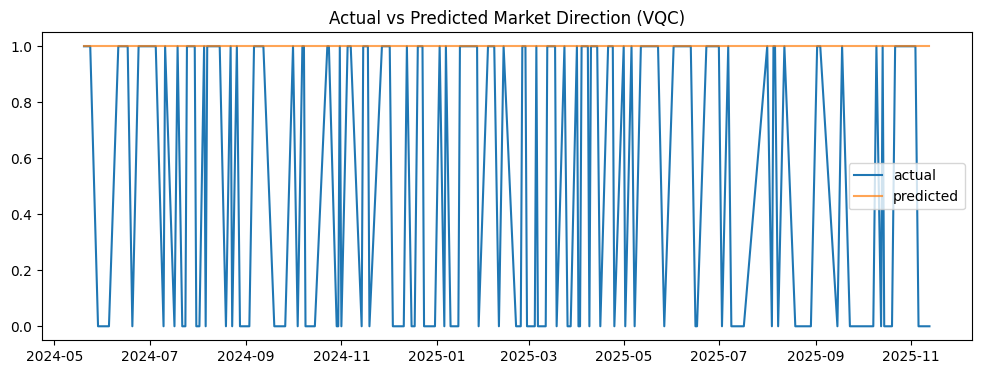

Filtered (|next-day return|>=2.5%) accuracy:
0.5263157894736842
[[ 0  9]
 [ 0 10]]
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         9
           1     0.5263    1.0000    0.6897        10

    accuracy                         0.5263        19
   macro avg     0.2632    0.5000    0.3448        19
weighted avg     0.2770    0.5263    0.3630        19



C:\Users\ADMIN\OneDrive\Attachments\Documents\STClub\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ADMIN\OneDrive\Attachments\Documents\STClub\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ADMIN\OneDrive\Attachments\Documents\STClub\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

In [10]:
yq_prob = predict_proba(X_test_pca, weights).ravel()
yq_pred = (yq_prob >= 0.5).astype(int)
acc_q = accuracy_score(y_test, yq_pred)
cm_q = confusion_matrix(y_test, yq_pred)
cr_q = classification_report(y_test, yq_pred, digits=4)
print(acc_q)
print(cm_q)
print(cr_q)
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].plot(hist_q['loss'])
axes[0].plot(hist_q['val_loss'])
axes[0].set_title('Training vs Validation Loss (VQC)')
axes[0].legend(['train','val'])
axes[1].plot(hist_q['loss'])
axes[1].plot(hist_q['val_loss'])
axes[1].set_title('Training vs Validation Accuracy (VQC proxy)')
axes[1].legend(['train','val'])
plt.show()
plt.figure(figsize=(12,4))
plt.plot(dates_test, y_test, label='actual')
plt.plot(dates_test, yq_pred, label='predicted', alpha=0.7)
plt.title('Actual vs Predicted Market Direction (VQC)')
plt.legend()
plt.show()
future_ret = (close_series.shift(-1) / close_series) - 1
fr_test = future_ret.loc[dates_test_seq]
mask = fr_test.abs() >= 0.05
acc_large = accuracy_score(y_test_seq[mask], y_pred[mask])
cm_large = confusion_matrix(y_test_seq[mask], y_pred[mask])
cr_large = classification_report(y_test_seq[mask], y_pred[mask], digits=4)
print('Filtered (|next-day return|>=2.5%) accuracy:')
print(acc_large)
print(cm_large)
print(cr_large)


## Save Models Locally and Upload

In [11]:
lstm_model.save('lstm_model.keras')
np.save('vqc_weights.npy', weights)
from huggingface_hub import HfApi, create_repo
token = os.getenv('HF_TOKEN')
if token:
    repo_id = 'market-direction-models'
    try:
        create_repo(repo_id, token=token, private=True, exist_ok=True)
    except Exception:
        pass
    api = HfApi()
    api.upload_file(path_or_fileobj='lstm_model.keras', path_in_repo='lstm_model.keras', repo_id=repo_id, token=token)
    api.upload_file(path_or_fileobj='vqc_weights.npy', path_in_repo='vqc_weights.npy', repo_id=repo_id, token=token)


## Weekly Direction (5-Day Ahead) LSTM

Best weekly threshold: 0.1
0.5555555555555556
[[ 0 56]
 [ 0 70]]
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        56
           1     0.5556    1.0000    0.7143        70

    accuracy                         0.5556       126
   macro avg     0.2778    0.5000    0.3571       126
weighted avg     0.3086    0.5556    0.3968       126



C:\Users\ADMIN\OneDrive\Attachments\Documents\STClub\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ADMIN\OneDrive\Attachments\Documents\STClub\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ADMIN\OneDrive\Attachments\Documents\STClub\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

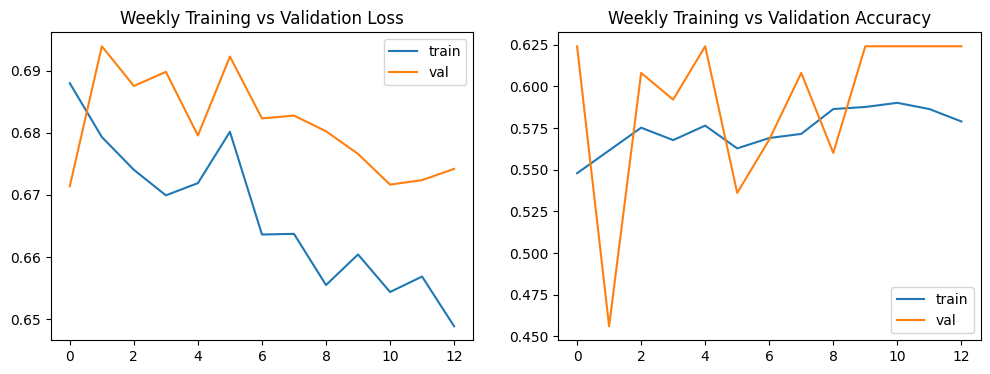

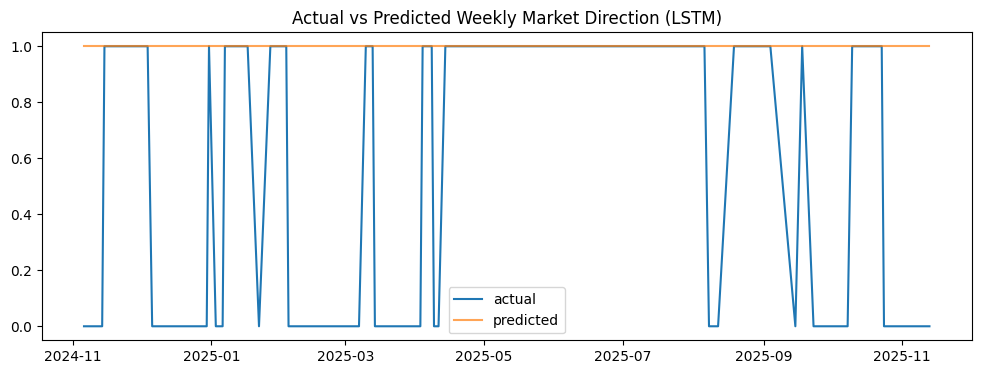

Filtered weekly (|5d return|>=5%) accuracy:
0.4482758620689655
[[ 0 16]
 [ 0 13]]
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        16
           1     0.4483    1.0000    0.6190        13

    accuracy                         0.4483        29
   macro avg     0.2241    0.5000    0.3095        29
weighted avg     0.2010    0.4483    0.2775        29



C:\Users\ADMIN\OneDrive\Attachments\Documents\STClub\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ADMIN\OneDrive\Attachments\Documents\STClub\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ADMIN\OneDrive\Attachments\Documents\STClub\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

In [12]:
df5 = df.copy()
df5['label5'] = (df5['close'].shift(-5) >= df5['close']).astype(int)
df5 = df5.dropna()
X5 = df5[features].values
y5 = df5['label5'].values
dates5 = df5.index
n5 = len(df5)
n5_train = int(n5*0.7)
n5_val = int(n5*0.15)
X5_train, X5_val, X5_test = X5[:n5_train], X5[n5_train:n5_train+n5_val], X5[n5_train+n5_val:]
y5_train, y5_val, y5_test = y5[:n5_train], y5[n5_train:n5_train+n5_val], y5[n5_train+n5_val:]
dates5_train, dates5_val, dates5_test = dates5[:n5_train], dates5[n5_train:n5_train+n5_val], dates5[n5_train+n5_val:]
scaler5 = MinMaxScaler()
X5_train_s = scaler5.fit_transform(X5_train)
X5_val_s = scaler5.transform(X5_val)
X5_test_s = scaler5.transform(X5_test)
X5_train_seq, y5_train_seq = make_sequences(X5_train_s, y5_train, window)
X5_val_seq, y5_val_seq = make_sequences(X5_val_s, y5_val, window)
X5_test_seq, y5_test_seq = make_sequences(X5_test_s, y5_test, window)
inputs5 = tf.keras.Input(shape=(window, X5_train.shape[1]))
x5 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(inputs5)
x5 = tf.keras.layers.Dropout(0.2)(x5)
x5 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x5)
x5 = tf.keras.layers.Dropout(0.2)(x5)
x5 = tf.keras.layers.LSTM(32)(x5)
x5 = tf.keras.layers.Dense(64, activation='relu')(x5)
out5 = tf.keras.layers.Dense(1, activation='sigmoid')(x5)
lstm5 = tf.keras.Model(inputs5, out5)
lstm5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
es5 = tf.keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True, monitor='val_accuracy', mode='max')
rlr5 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, min_lr=1e-5, mode='max')
hist5 = lstm5.fit(X5_train_seq, y5_train_seq, validation_data=(X5_val_seq, y5_val_seq), epochs=150, batch_size=64, callbacks=[es5, rlr5], verbose=0)
y5_val_prob = lstm5.predict(X5_val_seq, verbose=0).ravel()
ths = np.linspace(0.1, 0.9, 81)
vaccs = [accuracy_score(y5_val_seq, (y5_val_prob >= t).astype(int)) for t in ths]
best5_t = float(ths[int(np.argmax(vaccs))])
y5_test_prob = lstm5.predict(X5_test_seq, verbose=0).ravel()
y5_pred = (y5_test_prob >= best5_t).astype(int)
acc5 = accuracy_score(y5_test_seq, y5_pred)
cm5 = confusion_matrix(y5_test_seq, y5_pred)
cr5 = classification_report(y5_test_seq, y5_pred, digits=4)
print('Best weekly threshold:', best5_t)
print(acc5)
print(cm5)
print(cr5)
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].plot(hist5.history['loss'])
axes[0].plot(hist5.history['val_loss'])
axes[0].set_title('Weekly Training vs Validation Loss')
axes[0].legend(['train','val'])
axes[1].plot(hist5.history['accuracy'])
axes[1].plot(hist5.history['val_accuracy'])
axes[1].set_title('Weekly Training vs Validation Accuracy')
axes[1].legend(['train','val'])
plt.show()
plt.figure(figsize=(12,4))
plt.plot(dates5_test[window:], y5_test_seq, label='actual')
plt.plot(dates5_test[window:], y5_pred, label='predicted', alpha=0.7)
plt.title('Actual vs Predicted Weekly Market Direction (LSTM)')
plt.legend()
plt.show()
future5_ret = (close_series.shift(-5) / close_series) - 1
fr5_test = future5_ret.loc[dates5_test[window:]]
mask5 = fr5_test.abs() >= 0.10
acc5_large = accuracy_score(y5_test_seq[mask5], y5_pred[mask5])
cm5_large = confusion_matrix(y5_test_seq[mask5], y5_pred[mask5])
cr5_large = classification_report(y5_test_seq[mask5], y5_pred[mask5], digits=4)
print('Filtered weekly (|5d return|>=5%) accuracy:')
print(acc5_large)
print(cm5_large)
print(cr5_large)


## Monthly Direction (20-Day Ahead) LSTM

C:\Users\ADMIN\OneDrive\Attachments\Documents\STClub\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ADMIN\OneDrive\Attachments\Documents\STClub\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ADMIN\OneDrive\Attachments\Documents\STClub\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

Best monthly threshold: 0.1
0.48412698412698413
[[ 0 65]
 [ 0 61]]
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        65
           1     0.4841    1.0000    0.6524        61

    accuracy                         0.4841       126
   macro avg     0.2421    0.5000    0.3262       126
weighted avg     0.2344    0.4841    0.3158       126



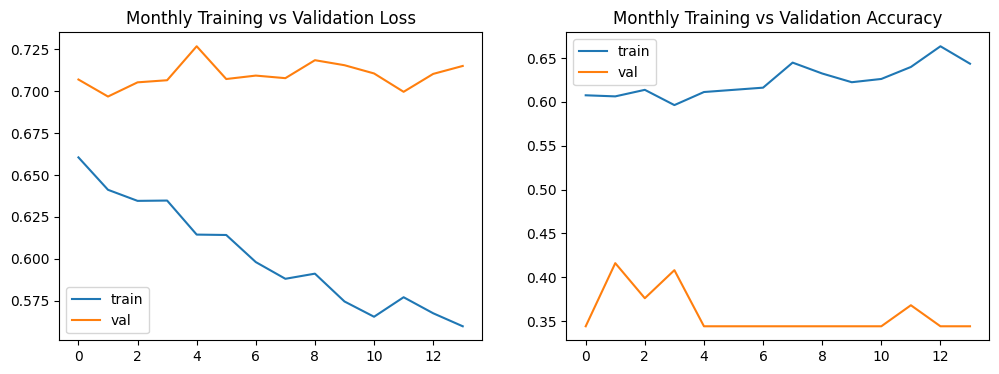

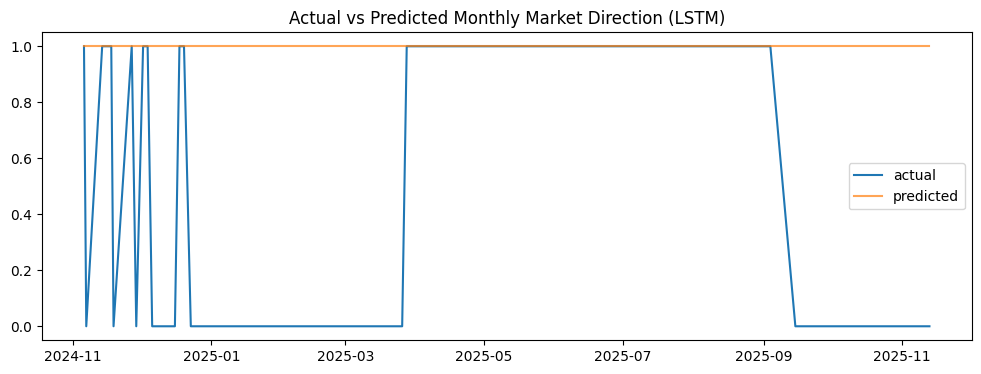

In [13]:
df20 = df.copy()
df20['label20'] = (df20['close'].shift(-20) >= df20['close']).astype(int)
df20 = df20.dropna()
X20 = df20[features].values
y20 = df20['label20'].values
dates20 = df20.index
n20 = len(df20)
n20_train = int(n20*0.7)
n20_val = int(n20*0.15)
X20_train, X20_val, X20_test = X20[:n20_train], X20[n20_train:n20_train+n20_val], X20[n20_train+n20_val:]
y20_train, y20_val, y20_test = y20[:n20_train], y20[n20_train:n20_train+n20_val], y20[n20_train+n20_val:]
dates20_train, dates20_val, dates20_test = dates20[:n20_train], dates20[n20_train:n20_train+n20_val], dates20[n20_train+n20_val:]
scaler20 = MinMaxScaler()
X20_train_s = scaler20.fit_transform(X20_train)
X20_val_s = scaler20.transform(X20_val)
X20_test_s = scaler20.transform(X20_test)
X20_train_seq, y20_train_seq = make_sequences(X20_train_s, y20_train, window)
X20_val_seq, y20_val_seq = make_sequences(X20_val_s, y20_val, window)
X20_test_seq, y20_test_seq = make_sequences(X20_test_s, y20_test, window)
inputs20 = tf.keras.Input(shape=(window, X20_train.shape[1]))
x20 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(inputs20)
x20 = tf.keras.layers.Dropout(0.2)(x20)
x20 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x20)
x20 = tf.keras.layers.Dropout(0.2)(x20)
x20 = tf.keras.layers.LSTM(32)(x20)
x20 = tf.keras.layers.Dense(64, activation='relu')(x20)
out20 = tf.keras.layers.Dense(1, activation='sigmoid')(x20)
lstm20 = tf.keras.Model(inputs20, out20)
lstm20.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
es20 = tf.keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True, monitor='val_accuracy', mode='max')
rlr20 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, min_lr=1e-5, mode='max')
hist20 = lstm20.fit(X20_train_seq, y20_train_seq, validation_data=(X20_val_seq, y20_val_seq), epochs=150, batch_size=64, callbacks=[es20, rlr20], verbose=0)
y20_val_prob = lstm20.predict(X20_val_seq, verbose=0).ravel()
ths20 = np.linspace(0.1, 0.9, 81)
vaccs20 = [accuracy_score(y20_val_seq, (y20_val_prob >= t).astype(int)) for t in ths20]
best20_t = float(ths20[int(np.argmax(vaccs20))])
y20_test_prob = lstm20.predict(X20_test_seq, verbose=0).ravel()
y20_pred = (y20_test_prob >= best20_t).astype(int)
acc20 = accuracy_score(y20_test_seq, y20_pred)
cm20 = confusion_matrix(y20_test_seq, y20_pred)
cr20 = classification_report(y20_test_seq, y20_pred, digits=4)
print('Best monthly threshold:', best20_t)
print(acc20)
print(cm20)
print(cr20)
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].plot(hist20.history['loss'])
axes[0].plot(hist20.history['val_loss'])
axes[0].set_title('Monthly Training vs Validation Loss')
axes[0].legend(['train','val'])
axes[1].plot(hist20.history['accuracy'])
axes[1].plot(hist20.history['val_accuracy'])
axes[1].set_title('Monthly Training vs Validation Accuracy')
axes[1].legend(['train','val'])
plt.show()
plt.figure(figsize=(12,4))
plt.plot(dates20_test[window:], y20_test_seq, label='actual')
plt.plot(dates20_test[window:], y20_pred, label='predicted', alpha=0.7)
plt.title('Actual vs Predicted Monthly Market Direction (LSTM)')
plt.legend()
plt.show()
